Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  # Consider only top 50000 words.
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)  # Assigning word id.
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK'] UNK = unknown.
      unk_count = unk_count + 1
    data.append(index)  # data: transferred text as a list of word ids.
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5237, 3081, 12, 6, 195, 2, 3135, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)  # Just for edge management.
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print(batch, labels)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'a', 'of']
[3081 3081   12   12    6    6  195  195] [[  12]
 [5237]
 [3081]
 [   6]
 [ 195]
 [  12]
 [   6]
 [   2]]

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'anarchism', 'term', 'originated', 'of', 'term', 'as']
[12 12 12 12  6  6  6  6] [[   6]
 [3081]
 [5237]
 [ 195]
 [3081]
 [   2]
 [ 195]
 [  12]]


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print(embed)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Tensor("embedding_lookup:0", shape=(128, 128), dtype=float32, device=/device:CPU:0)


In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.921964
Nearest to called: floppy, says, deoxyribose, powerfully, gutenberg, xenophon, nail, emmy,
Nearest to was: inexplicable, conform, sailor, condita, symptoms, chroma, manifestation, stored,
Nearest to have: predicting, courtship, conditional, platters, sobib, curlers, hangings, carom,
Nearest to such: overwrite, mediawiki, discontinue, purpurea, tokyo, discord, zoroastrian, diaphragm,
Nearest to between: passed, technicians, slum, unaccustomed, eszterh, antrim, lutes, hermeneutic,
Nearest to to: medication, facilitated, interquartile, nawab, cultures, bitumen, rearward, conjectural,
Nearest to up: doe, outta, barter, feminist, apuleius, adjoined, osiris, theoretical,
Nearest to and: funimation, waite, mitford, swelling, talib, ifad, disadvantaged, channel,
Nearest to state: virgil, acr, carangi, pierce, undirected, oligopoly, heschel, champion,
Nearest to from: arc, tout, wallenberg, forgiveness, batsman, colleague, disability, heuristics,
Nea

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

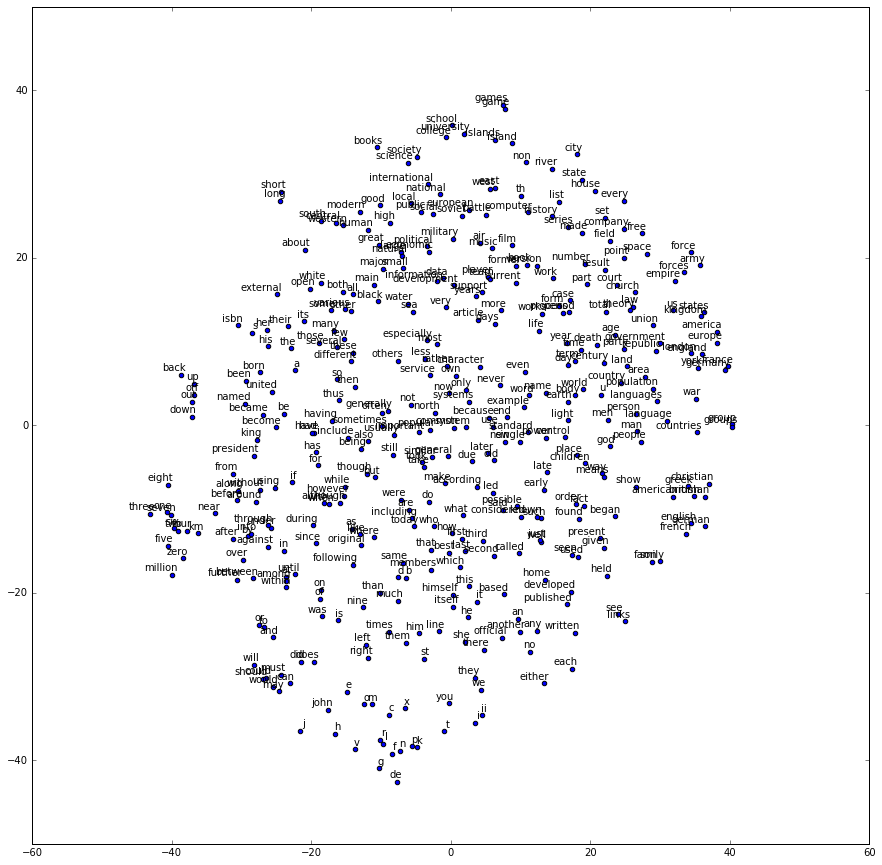

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [10]:
data_index = 0

def generate_batch_cbow(batch_size, window):
  global data_index
  batch = []
  labels = []

  for i in range(batch_size):
    labels.append(data[data_index + window + i])
    batch_element = []
    for j in range(window):
      batch_element.append(data[data_index + window + i - j - 1])
      batch_element.append(data[data_index + window + i + j + 1])
    batch.append(batch_element)
  return np.array(batch, dtype=np.int32), np.array(labels, dtype=np.int32).reshape(batch_size, 1)

print('data:', [reverse_dictionary[di] for di in data[:8]])

for window in [2, 5]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, window=window)
    print('\nwith window = %d:' % (window))
    print('    batch:', [','.join([reverse_dictionary[i] for i in bi]) for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print(batch, labels)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with window = 2:
    batch: ['originated,a,anarchism,term', 'as,term,originated,of', 'a,of,as,abuse', 'term,abuse,a,first', 'of,first,term,used', 'abuse,used,of,against', 'first,against,abuse,early', 'used,early,first,working']
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
[[3081    6 5237  195]
 [  12  195 3081    2]
 [   6    2   12 3135]
 [ 195 3135    6   46]
 [   2   46  195   59]
 [3135   59    2  156]
 [  46  156 3135  128]
 [  59  128   46  742]] [[  12]
 [   6]
 [ 195]
 [   2]
 [3135]
 [  46]
 [  59]
 [ 156]]

with window = 5:
    batch: ['term,abuse,a,first,as,used,originated,against,anarchism,early', 'of,first,term,used,a,against,as,early,originated,working', 'abuse,used,of,against,term,early,a,working,as,class', 'first,against,abuse,early,of,working,term,class,a,radicals', 'used,early,first,working,abuse,class,of,radicals,term,including', 'against,working,used,class,fi

In [11]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
window = 2 # How many words to consider left and right.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, window * 2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.reduce_sum(tf.nn.embedding_lookup(embeddings, train_dataset), [1])
    
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [12]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(
      batch_size, window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.197861
Nearest to have: motorways, phys, rshavn, critically, moto, wenceslaus, oxford, theatrical,
Nearest to not: cia, plagioclase, cadres, summarizes, psychical, sadly, understood, explain,
Nearest to can: montju, limewire, demonstrating, luz, uu, carla, whitespace, asmara,
Nearest to state: pluto, ack, washington, lymphatic, starships, windsor, morava, avicenna,
Nearest to that: rovers, samoa, veritas, fewest, outbreaks, messier, recanted, rival,
Nearest to six: daoud, password, kosova, kinky, pollutant, chrismation, livonian, brutality,
Nearest to more: startup, quiet, high, manfred, withdraws, zanu, deum, succeed,
Nearest to the: triphosphate, gator, closures, mcluhan, proof, wilbur, galatia, diametrically,
Nearest to to: clerical, burdensome, reuss, multilateral, supervisory, deer, dod, mats,
Nearest to three: bessarabia, decca, food, chorus, silky, alkoxide, geometry, ir,
Nearest to would: dan, sicilian, constituci, succeed, backgammon, helm

In [13]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

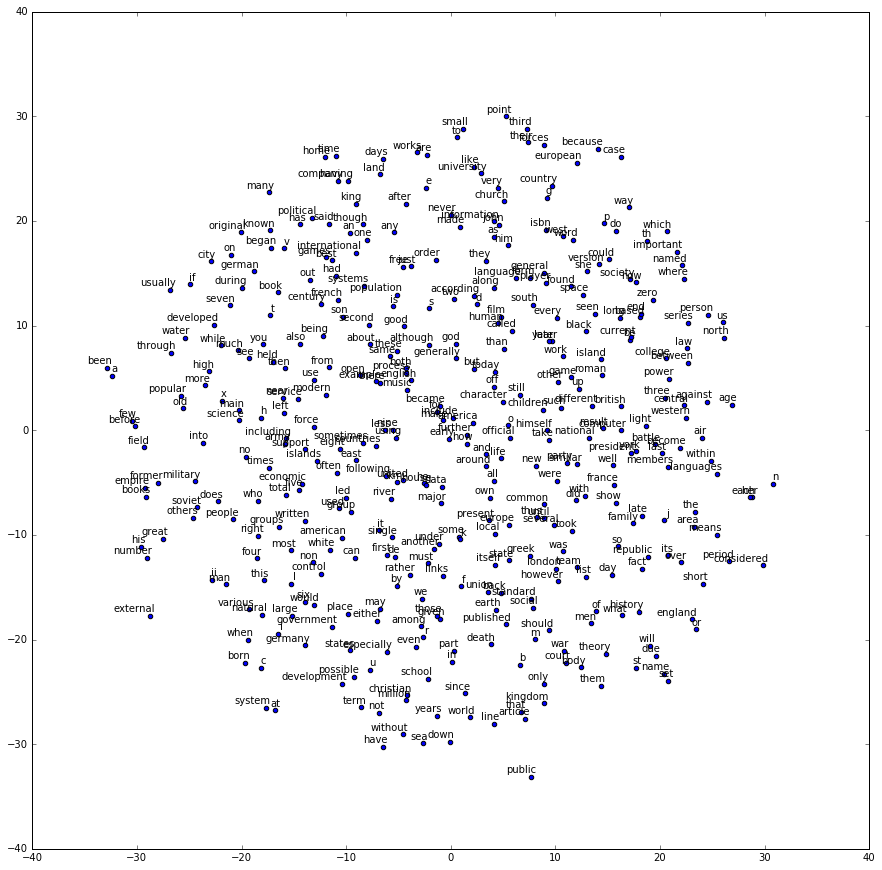

In [14]:
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)